<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week3/linear_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear neuron

##1. LSQ Algorithm and Gradient descent algorithm
- and the SSE (The Sum squared error), SAE (The Sum absolute error), MSE (The Mean squared error), MAE (The Mean absolute error) functions



In [147]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

class LinearNeuron:
    def __init__(self, input_dim, init_method='zero'):
        # weight initialization:
        if init_method == 'random':
            self.weights = np.random.uniform(-1, 1, (input_dim, 1)) / 10  # Random initialization
            self.bias = float(np.random.uniform(-1, 1) / 10)
        elif init_method == 'widrow-hoff':
            self.weights = np.random.randn(input_dim, 1) * (2 / np.sqrt(input_dim))  # Widrow-Hoff rule
            self.bias = float(np.random.randn() * (2 / np.sqrt(input_dim)))
        else: # init_method == 'zero':
            self.weights = np.zeros((input_dim, 1))  # Initialize weights to zeros
            self.bias = 0.0
        self.epochs = -1

    def set_weights(self, weights, bias):
        self.weights = np.array(weights, dtype=float).reshape(-1, 1)
        self.bias = float(bias)

    def __str__(self):
        return f"LinearNeuron(weights={self.weights.T}, bias={self.bias})"

    def activation(self, x):
        return x

    def forward(self, inputs):
        potential = np.dot(inputs, self.weights) + self.bias
        #potential = inputs @ self.weights + self.bias
        return self.activation(potential).flatten()

    def LSQ(self, training_inputs, true_outputs):
        X_aug = np.hstack([training_inputs, np.ones((training_inputs.shape[0], 1))]) # extend input by ones

        weights_aug, _, _, _ = np.linalg.lstsq(X_aug, true_outputs, rcond=None)  # using library function

        self.weights = weights_aug[:-1].reshape(-1, 1)  # ensure column vector
        self.bias = float(weights_aug[-1].item())

    def LSQ_pseudoinverse(self, training_inputs, true_outputs):
        X_aug = np.hstack([training_inputs, np.ones((training_inputs.shape[0], 1))]) # extend input by ones

        weights_aug = np.linalg.pinv(X_aug.T @ X_aug) @ X_aug.T @ true_outputs       # Moore-Penrose pseudoinverse

        self.weights = weights_aug[:-1].reshape(-1, 1)  # Ensure column vector
        self.bias = float(weights_aug[-1].item())

    def LSQ_tichonov(self, training_inputs, true_outputs, lambda_reg=1e-5):
        X_aug = np.hstack([training_inputs, np.ones((training_inputs.shape[0], 1))]) # extend input by ones

        n = X_aug.shape[1]
        weights_aug = np.linalg.solve((X_aug.T @ X_aug) + np.eye(n) * lambda_reg, X_aug.T @ true_outputs)

        self.weights = weights_aug[:-1].reshape(-1, 1)  # Ensure column vector
        self.bias = float(weights_aug[-1].item())

    def gradient_descent_iterative(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, max_validation_steps=None, validation_set = None,  print_progress=False):
        if print_progress:
            print("Gradient Descent iterative:")
        learning_rate_0 = learning_rate # initial learning rate
        training_errors = []
        validation_errors = []

        if validation_set is not None:
            validation_inputs, validation_true_outputs = validation_set
            validation_steps = 0
            previous_validation_error = MSE_error(validation_true_outputs.flatten(), self.forward(validation_inputs))

        for epoch in range(epochs):

            # Shuffle the training data for each epoch
            shuffled_indices = np.random.permutation(len(training_inputs))
            training_inputs = training_inputs[shuffled_indices]
            true_outputs = true_outputs[shuffled_indices]

            for inputs, true_output in zip(training_inputs, true_outputs):
                prediction = self.forward(inputs.T).reshape(-1, 1)  # Ensure row vector for forward pass
                error = true_output - prediction
                self.weights += learning_rate * error * inputs.reshape(-1, 1)  # Update weights
                self.bias += float((learning_rate * error).item())             # Update bias

            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)

            # Validation:
            if validation_set:
                validation_mse = MSE_error(validation_true_outputs.flatten(), self.forward(validation_inputs))
                validation_errors.append(validation_mse)
                if validation_mse < previous_validation_error:
                    validation_steps = 0
                else:
                    validation_steps += 1
                previous_validation_error = validation_mse

            mse = MSE_error(true_outputs.flatten(), self.forward(training_inputs))
            training_errors.append(mse)
            if print_progress:
                if validation_set:
                    print(f"Epoch: {epoch}, Training MSE: {mse:0.4f}, Validation MSE: {validation_mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")
                else:
                    print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            # Stop conditions:
            if (mse <= min_error):
                msg = "Minimum error reached."
                break
            elif (max_validation_steps and validation_steps > max_validation_steps):
                msg = "Maximum validation steps reached."
                break
            else:
                msg = "Maximum epochs reached."
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.", msg)
        self.epochs = epoch+1
        return training_errors, validation_errors


    def gradient_descent_batch(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, max_validation_steps=None, validation_set = None,  print_progress=False):
        if print_progress:
            print("Gradient Descent batch:")

        training_inputs = np.array(training_inputs)  # (m, n)
        true_outputs = np.array(true_outputs).reshape(-1, 1)  # (m, 1)
        batch_size = training_inputs.shape[0]  # Scalar

        learning_rate_0 = learning_rate # initial learning rate
        training_errors = []
        validation_errors = []

        if validation_set is not None:
            validation_inputs, validation_true_outputs = validation_set
            validation_steps = 0
            previous_validation_error = MSE_error(validation_true_outputs.flatten(), self.forward(validation_inputs))

        for epoch in range(epochs):
            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)
            prediction = self.forward(training_inputs).reshape(-1, 1)  # (m, 1)
            errors = true_outputs - prediction  # (m, 1)
            weight_gradient = (training_inputs.T @ errors)   # (n, 1)
            bias_gradient = np.sum(errors)  # Scalar

            self.weights += learning_rate * weight_gradient  # (n, 1)
            self.bias += learning_rate * bias_gradient  # Scalar

            # Validation:
            if validation_set:
                validation_mse = MSE_error(validation_true_outputs.flatten(), self.forward(validation_inputs))
                validation_errors.append(validation_mse)
                if validation_mse < previous_validation_error:
                    validation_steps = 0
                else:
                    validation_steps += 1
                previous_validation_error = validation_mse
            mse = MSE_error(true_outputs.flatten(), self.forward(training_inputs))  # (m,)
            training_errors.append(mse)

            if print_progress:
                if validation_set:
                    print(f"Epoch: {epoch}, Training MSE: {mse:0.4f}, Validation MSE: {validation_mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")
                else:
                    print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            # Stop conditions:
            if (mse <= min_error):
                msg = "Minimum error reached."
                break
            elif (max_validation_steps and validation_steps > max_validation_steps):
                msg = "Maximum validation steps reached."
                break
            else:
                msg = "Maximum epochs reached."
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.", msg)

        self.epochs = epoch + 1
        return training_errors, validation_errors

def sign(x):
    return np.where(x > 0, 1, np.where(x < 0, -1, 0))

def perceptron_error(true_outputs, predicted_outputs):
    return np.sum(true_outputs != predicted_outputs)

def SSE_error(true_outputs, predicted_outputs):
    # The Sum squared error
    return np.sum((true_outputs - predicted_outputs) ** 2)
def SAE_error(true_outputs, predicted_outputs):
    # The Sum absolute error
    return np.sum(np.abs(true_outputs - predicted_outputs))
def MAE_error(true_outputs, predicted_outputs):
    # The Mean absolute error
    return np.mean(np.abs(true_outputs - predicted_outputs))
def MSE_error(true_outputs, predicted_outputs):
    # The Mean squared error
    return np.mean((true_outputs - predicted_outputs) ** 2)

### Auxiliary functions:

In [148]:

def plot_regression_3D(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression plane in 3D."""

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the data points
    ax.scatter(training_inputs[:, 0], training_inputs[:, 1], true_outputs.flatten(),
               label="Data points", color='blue', alpha=0.4, s=50)

    # Create a meshgrid for the plane
    x_range = np.linspace(min(training_inputs[:, 0]), max(training_inputs[:, 0]), 20)
    y_range = np.linspace(min(training_inputs[:, 1]), max(training_inputs[:, 1]), 20)
    X, Y = np.meshgrid(x_range, y_range)

    # Calculate Z values for the plane using the perceptron's weights and bias
    Z = perceptron.weights[0] * X + perceptron.weights[1] * Y + perceptron.bias

    # Plot the regression plane
    ax.plot_surface(X, Y, Z, alpha=0.5, facecolors=plt.cm.Reds(Z), edgecolor='k', rstride=1, cstride=1)

    # Labels
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    ax.set_zlabel("y")
    ax.set_title("3D Linear Regression Fit")

    plt.show()

def plot_decision_boundary_2D(perceptron, training_inputs, true_outputs):
    """Plots the decision boundary of the perceptron."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract the first two columns of training_inputs
    x1 = training_inputs[:, 0]
    x2 = training_inputs[:, 1]

    # Generate points for visualization
    x_min, x_max = np.min(x1) - 1, np.max(x1) + 1  # Extend the range slightly
    y_min, y_max = np.min(x2) - 1, np.max(x2) + 1  # Extend the range slightly

    x = np.linspace(x_min, x_max, 100)
    weights = perceptron.weights.flatten()
    y = -(weights[0] * x + perceptron.bias) / weights[1]

    plt.figure(figsize=(5, 3))
    # Plot the decision boundary
    plt.plot(x, y, label='Decision Boundary')

    # Plot the points
    for i, input_vector in enumerate(training_inputs):
        if true_outputs[i] == 1:
            plt.scatter(input_vector[0], input_vector[1], color='green', label='Class 1' if i == 0 else "")  # Add label only for the first point of each class
        else:
            plt.scatter(input_vector[0], input_vector[1], color='red', label='Class -1' if i == 0 else "")

    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.title('Perceptron Decision Boundary', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)  # Set y-axis limits

    # Highlight x and y axes
    plt.axhline(0, color='black', linewidth=0.8)  # x-axis
    plt.axvline(0, color='black', linewidth=0.8)  # y-axis
    plt.show()

def plot_regression(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression line."""
    plt.figure(figsize=(4, 3))

    # Plot the data points
    plt.scatter(training_inputs, true_outputs, label="Data points", color='blue', alpha=0.6)

    # Generate predictions for the regression line
    X_test = np.linspace(-1, 1, 100).reshape(-1, 1)
    d_pred = perceptron.weights * X_test + perceptron.bias

    plt.plot(X_test, d_pred, label="Regression line", color='red', linewidth=2)
    plt.xlabel("x_1")
    plt.ylabel("y")
    plt.legend()
    plt.title("Linear Regression Fit")
    plt.show()

def plot_error_progress(train_errors, validation_errors):
    fig = plt.figure(figsize=(4, 3))
    plt.plot(validation_errors, label='Validation Error')
    plt.plot(train_errors, label='Train Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Validation and Train Error Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_example_LSQ(experiment_results, inputs, true_outputs, init_method, variant, data_description):
    times = []
    errors = []
    epoch_counts = []

    start_time = time.time()
    perceptron = LinearNeuron(inputs.shape[1], init_method)
    if variant == 'pseudoinverse':
        perceptron.LSQ_pseudoinverse(inputs, true_outputs)
    elif variant == 'tichonov':
        perceptron.LSQ_tichonov(inputs, true_outputs)
    elif variant == 'library':
        perceptron.LSQ(inputs, true_outputs)
    elif variant == 'gradient':
        perceptron.gradient_descent_iterative(inputs, true_outputs)
    elif variant == 'batch':
        perceptron.gradient_descent_batch(inputs, true_outputs)
    end_time = time.time()
    elapsed_time = end_time - start_time

    real_outputs = perceptron.forward(inputs)
    error_MSE = MSE_error(true_outputs, real_outputs)
    error_SSE = SSE_error(true_outputs, real_outputs)

    results = {
        'MSE': error_MSE,
        'SSE': error_SSE,
        'Time': elapsed_time,
        'Variant': variant,
        'Weights': perceptron.weights,
        'Bias': perceptron.bias,
        'Data Description': data_description
    }
    experiment_results.loc[len(experiment_results)] = results


def run_example_multiple_times(experiment_results, training_data, testing_data, validation_data, epochs, init_method, learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=10, num_runs=10):
    inputs, true_outputs = training_data
    if testing_data is None:
        testing_data = training_data
    max_validation_steps = None if validation_data is None else max_validation_steps
    test_inputs, test_true_outputs = testing_data
    times = []
    mse_errors = []
    mae_errors = []
    mse_test_errors = []
    mae_test_errors = []
    epoch_counts = []

    for _ in range(num_runs):

        start_time = time.time()
        neuron = LinearNeuron(inputs.shape[1], init_method)

        if variant == 'iterative':
            neuron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress)
        elif variant == 'batch':
            neuron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress, print_progress=print_progress)
        elif variant == 'pseudoinverse':
            neuron.LSQ_pseudoinverse(inputs, true_outputs)
        elif variant == 'tichonov':
            neuron.LSQ_tichonov(inputs, true_outputs)
        else:
            neuron.LSQ(inputs, true_outputs)

        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = neuron.forward(inputs)
        mse = MSE_error(true_outputs, real_outputs)
        mae = MAE_error(true_outputs, real_outputs)

        real_outputs = neuron.forward(test_inputs)
        mse_test = MSE_error(test_true_outputs, real_outputs)
        mae_test = MAE_error(test_true_outputs, real_outputs)

        times.append(elapsed_time)
        mse_errors.append(mse)
        mae_errors.append(mae)
        mse_test_errors.append(mse_test)
        mae_test_errors.append(mae_test)
        epoch_counts.append(neuron.epochs)

    avg_time = np.mean(times)
    avg_mse = np.mean(mse_errors)
    avg_mae = np.mean(mae_errors)
    avg_test_mse = np.mean(mse_test_errors)
    avg_test_mae = np.mean(mae_test_errors)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'MSE': avg_mse,
        'MAE': avg_mae,
        'Test MSE': avg_test_mse,
        'Test MAE': avg_test_mae,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': neuron.weights,  # Note: Weights and bias are from the last run.
        'Bias': neuron.bias,
        'Data Description': data_description
    } #experiment_results_r = pd.DataFrame(columns=['MSE', 'SSE', 'Test MSE' 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

    experiment_results.loc[len(experiment_results)] = results

### Example 1
- train the linear neuron on the given data:
- you can change the training data ant the variant of LSQ:
- observe carefully the predicted values

LinearNeuron(weights=[[-0.5 -0.5]], bias=0.5)
LSQ: pseudoinverse
Perceptron error: 4
SSE error: 1.0
MSE error: 0.25
SAE error: 2.0
MAE error: 0.5


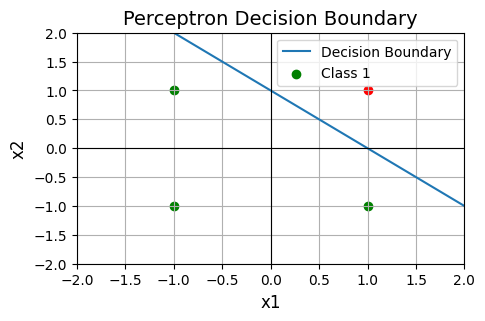

,Input,Predicted,True
0,"[-1, -1]",[1.5],1
1,"[-1, 1]",[0.5],1
2,"[1, -1]",[0.5],1
3,"[1, 1]",[-0.5],-1


In [149]:
# Example 1 from the presentation:
# Data:
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])
#variant = "tichonov"
variant = "pseudoinverse"
#variant = "library"

# Linear Neuron parameters:
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- comparison of LSQ variants:

In [150]:
# Example 1
# Data and parameters:
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])
data_description = "Ex. 1"
init_method = 'zero'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1


Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,0.250000,1.000000,0.000651,library,"[[-0.5], [-0.49999999999999994]]",0.500000,Ex. 1
1,0.250000,1.000000,0.000308,pseudoinverse,"[[-0.5], [-0.5]]",0.500000,Ex. 1
2,0.250000,1.000000,0.000136,tichonov,"[[-0.49999875000312505], [-0.49999875000312505]]",0.499999,Ex. 1
3,0.250051,1.000202,0.017208,gradient,"[[-0.5063844027104115], [-0.5026919856226783]]",0.498412,Ex. 1
4,0.250000,1.000000,0.006590,batch,"[[-0.49999999999999994], [-0.5]]",0.500000,Ex. 1


### Example 2
- train the linear neuron on the given data:
- you can change the training data ant the variant of LSQ:

LinearNeuron(weights=[[ 0.       -0.999995]], bias=0.0)
LSQ: tichonov
Perceptron error: 2
SSE error: 4.999950000408418e-11
MSE error: 2.499975000204209e-11
SAE error: 9.99995000028342e-06
MAE error: 4.99997500014171e-06


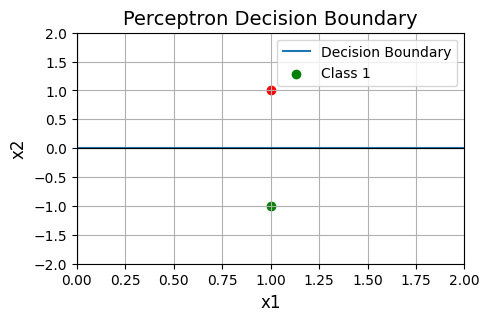

,Input,Predicted,True
0,"[1, -1]",[0.9999950000249999],1
1,"[1, 1]",[-0.9999950000249999],-1


In [151]:
# Example 2 from the presentation:
# Data:
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
#variant = "library"
#variant = "pseudoinverse"
variant = "tichonov"

# Linear Neuron parameters:
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


-comparison of LSQ variants:

In [152]:
# Example 2 from the presentation:
# Data and parameters:
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
data_description = "Ex. 2"
init_method = 'zero'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1 #.round(5)




Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,3.204747e-31,6.409495e-31,0.000208,library,"[[-3.3306690738754696e-16], [-1.00000000000000...",-2.775558e-16,Ex. 2
1,0.000000e+00,0.000000e+00,0.000257,pseudoinverse,"[[0.0], [-1.0]]",0.000000e+00,Ex. 2
2,2.499975e-11,4.999950e-11,0.000134,tichonov,"[[0.0], [-0.9999950000249999]]",0.000000e+00,Ex. 2
3,4.930381e-32,9.860761e-32,0.017514,gradient,"[[-8.25388090214771e-18], [-0.9999999999999998]]",-8.253881e-18,Ex. 2
4,0.000000e+00,0.000000e+00,0.000356,batch,"[[0.0], [-1.0]]",0.000000e+00,Ex. 2


### Example: XOR

LinearNeuron(weights=[[0. 0.]], bias=0.0)
LSQ: pseudoinverse
Perceptron error: 4
SSE error: 4.0
MSE error: 1.0
SAE error: 4.0
MAE error: 1.0


<ipython-input-148-c5c8aa3fe786>:45: RuntimeWarning: invalid value encountered in divide
  y = -(weights[0] * x + perceptron.bias) / weights[1]


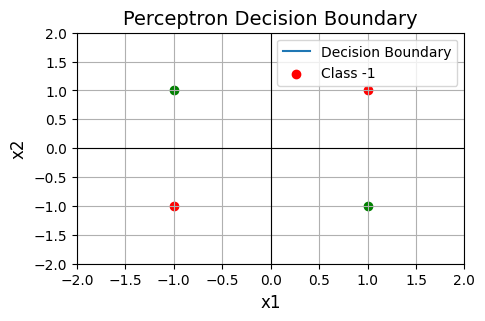

,Input,Predicted,True
0,"[-1, -1]",[0.0],-1
1,"[-1, 1]",[0.0],1
2,"[1, -1]",[0.0],1
3,"[1, 1]",[0.0],-1


In [153]:
# Example XOR:
# Data:
inputs = np.array([ [-1, -1],
                    [-1,  1],
                    [ 1, -1],
                    [ 1,  1]])
true_outputs = np.array([-1, 1, 1, -1])
#variant = "library"
variant = "pseudoinverse"
#variant = "tichonov"

# Linear Neuron parameters:
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df

### Example 3: Linear regression


- create the data:

In [154]:
def generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100):
    # y = A x1 + B + noise

    # Define true function with noise
    inputs = np.random.uniform(-1, 1, size=(number_of_samples, 1))  # Random values between -1 and 1
    noise = np.random.normal(0, std_noise, size=inputs.shape)  # Gaussian noise

    true_outputs = A * inputs[:, [0]]  + B + noise
    return inputs, true_outputs.flatten()

inputs, true_outputs = generate_regression_data_1D()

- train the linear neuron on the data
- you can change the true outputs and the level of additive noise in the data


LinearNeuron(weights=[[1.51414235]], bias=2.968829897089611)
LSQ: pseudoinverse
Perceptron error: 100
MSE error: 0.09336056169626383
MAE error: 0.2430479047377812


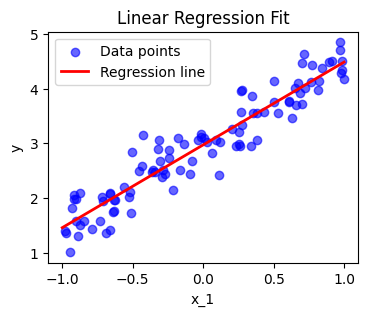

,Input,Predicted,True
0,[0.6554394955820162],[3.961258597825209],3.691509
1,[0.2639149307800577],[3.368434671632838],2.951766
2,[0.11393506752089677],[3.141343808427194],2.421203
3,[-0.7330619910606819],[1.8588696883277205],1.584005
4,[-0.42508577299183403],[2.3251895241260256],3.151558
...,...,...,...
95,[-0.8742034847862816],[1.6451613747730165],1.510661
96,[-0.24328915187462496],[2.6004554879710398],2.880162
97,[0.717850777061386],[4.055758162479631],4.626189
98,[-0.5583501682443679],[2.123408258995905],2.204321


In [155]:
# Example: simple linear regression
# Data and parameters:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

#variant = "library"
variant = "pseudoinverse"
#variant = "tichonov"
init_method = 'random'

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
#print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
#print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_regression(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df

- comparison of LSQ variants:

In [156]:

# Data and parameters:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
data_description = "Lin. regr. 1"
init_method = 'random'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1


Experiment Results:


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,9.303089e-02,9.303089e+00,0.000270,library,[[1.5420724280590303]],3.023998e+00,Lin. regr. 1
1,9.303089e-02,9.303089e+00,0.000753,pseudoinverse,[[1.5420724280590319]],3.023998e+00,Lin. regr. 1
2,9.303089e-02,9.303089e+00,0.000167,tichonov,[[1.5420719666877079]],3.023998e+00,Lin. regr. 1
3,9.584857e-02,9.584857e+00,0.130859,gradient,[[1.5793641184461866]],2.975655e+00,Lin. regr. 1
4,8.530355e+236,8.530355e+238,0.003312,batch,[[1.5403071239652587e+116]],-2.920610e+118,Lin. regr. 1


- observe how the level of noise in the data affects the training and error

In [157]:
# Data and parameters
data_description = "Lin. regr. 1"
init_method = 'zero'
variant = 'pseudoinverse'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for std_noise in [0.01, 0.1, 1, 10]:
    np.random.seed(42)
    inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=std_noise, number_of_samples=100)
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1 #.round(5)


Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,0.000081,0.008066,0.000187,pseudoinverse,[[1.4977011338643844]],2.999852,Lin. regr. 1
1,0.008066,0.806585,0.000152,pseudoinverse,[[1.4770113386438481]],2.998521,Lin. regr. 1
2,0.806585,80.658456,0.000135,pseudoinverse,[[1.2701133864384833]],2.985210,Lin. regr. 1
3,80.658456,8065.845640,0.000148,pseudoinverse,[[-0.7988661356151623]],2.852095,Lin. regr. 1


### Example 4 - Linear regression with two input dimensions

- create and observe the data:

In [232]:
def generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.3, number_of_samples=100):
    # y = A x1 + B x2 + C + noise

    # Generate x1 and x2 from a uniform distribution (more variation than linspace)
    x1 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = x2[np.random.permutation(number_of_samples)]  # Randomly shuffle x2
    inputs = np.hstack([x1, x2])

    # Define true function with noise
    noise = np.random.normal(0, std_noise, size=x1.shape)  # Gaussian noise
    true_outputs = A*x1 + B*x2 + C + noise
    return inputs, true_outputs.flatten()

inputs, true_outputs = generate_regression_data_2D()

- train the linear neuron on the data
- you can change the true outputs and the level of additive noise in the data





LinearNeuron(weights=[[1.48209421 1.95702967]], bias=-4.072234605590909)
LSQ: pseudoinverse
Perceptron error: 10000
MSE error: 10.511559430941812
MAE error: 2.6163575796138576


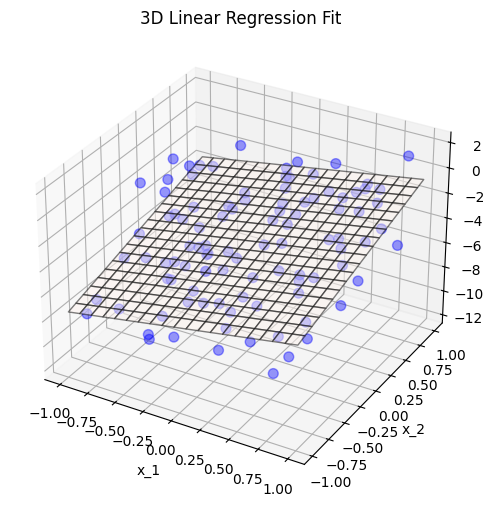

(100, 2)


,Input,Predicted,True
0,"[0.8480835182148663, -0.8453578690224255]",[-4.46968536622701],[-6.482989865931279]
1,"[-0.5277669337651913, 0.2675171274403545]",[-4.3308959663038165],[-6.596371690767622]
2,"[0.5199108178751712, 0.5571438781015021]",[-2.21133069228865],[-5.463194660116152]
3,"[0.06253150794706808, -0.6689589792654205]",[-5.288729590918541],[-1.4700965862453286]
4,"[0.4410321227829297, 0.5048062400776454]",[-2.4306626600888768],[-4.707270111574011]
...,...,...,...
95,"[-0.1829634141281662, -0.7955746715496008]",[-5.9003668600861285],[-3.557833769809722]
96,"[0.8658761341999093, -0.6273582410117586]",[-4.0166832927886835],[-4.8028905877524455]
97,"[0.9818589529147812, 0.06371495937634797]",[-2.4923350706618663],[-1.5076754139921724]
98,"[-0.5899963798935255, 0.9181495891280556]",[-3.149818835571548],[-1.394118000792578]


In [140]:
# Define parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=2.5, number_of_samples=100)

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == "library":
    perceptron.LSQ(inputs, true_outputs)
elif variant == "pseudoinverse":
    perceptron.LSQ_pseudoinverse(inputs, true_outputs)
elif variant == "tichonov":
    perceptron.LSQ_tichonov(inputs, true_outputs)

# Print summary:
print(perceptron)
print("LSQ:", variant)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
print(f"Perceptron error: {perceptron_error(true_outputs, real_outputs)}")
#print(f"SSE error: {SSE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
#print(f"SAE error: {SAE_error(true_outputs, real_outputs)}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
plot_regression_3D(perceptron, inputs, true_outputs)
print(np.shape(inputs))

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


In [141]:
# Data and parameters:
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=2.5, number_of_samples=100)
data_description = "Lin. regr. 2"
init_method = 'random'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for variant in ['library', 'pseudoinverse', 'tichonov', 'gradient', 'batch']:
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1


Experiment Results:


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,1.812383e+01,1.812383e+05,0.000242,library,"[[2.2083069220220115], [3.5073431509007627]]",-3.899539e+00,Lin. regr. 2
1,1.812383e+01,1.812383e+05,0.000287,pseudoinverse,"[[2.208306922022011], [3.5073431509007587]]",-3.899539e+00,Lin. regr. 2
2,1.812383e+01,1.812383e+05,0.000129,tichonov,"[[2.2083062137610687], [3.507342039389929]]",-3.899538e+00,Lin. regr. 2
3,1.852757e+01,1.852757e+05,0.117736,gradient,"[[2.5235545254742378], [3.4108743952878737]]",-4.260266e+00,Lin. regr. 2
4,2.220246e+238,2.220246e+242,0.003087,batch,"[[1.1199127215744945e+118], [1.887307971429851...",1.462713e+119,Lin. regr. 2


- observe how the level of noise in the data affects the training and error

In [142]:
# Data and parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=2.5, number_of_samples=100)
data_description = "Lin. regr. 2"
init_method = 'zero'
variant = 'pseudoinverse'

# Run experiment:
experiment_results_1 = pd.DataFrame(columns=['MSE', 'SSE', 'Time', 'Variant', 'Weights', 'Bias', 'Data Description'])
for std_noise in [0.01, 0.1, 1, 2]:
    np.random.seed(42)
    inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C = -4, std_noise=std_noise, number_of_samples=100)
    run_example_LSQ(experiment_results_1, inputs, true_outputs, init_method, variant, data_description)
print("\nExperiment Results:")
experiment_results_1 #.round(5)


Experiment Results:


,MSE,SSE,Time,Variant,Weights,Bias,Data Description
0,9.469434,94694.337416,0.000198,pseudoinverse,"[[2.0033162865773786], [2.995430899968277]]",-3.999275,Lin. regr. 2
1,9.398240,93982.402026,0.000149,pseudoinverse,"[[2.0331628657738046], [2.954308999682752]]",-3.992748,Lin. regr. 2
2,9.797116,97971.159983,0.000139,pseudoinverse,"[[2.3316286577380607], [2.543089996827503]]",-3.927485,Lin. regr. 2
3,12.609044,126090.444963,0.000129,pseudoinverse,"[[2.6632573154761228], [2.0861799936550036]]",-3.854970,Lin. regr. 2


##2. Iterative and batch gradient descent algorithm:


### Example 1
- In this example, we train the linear neuron a classification task
- Observe the training process, does the algorithm converge?
- Are the predicted outputs close to the expected ones?
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process
- Try to initialize weights with large values and observe, how it affects training

Gradient Descent iterative:
Epoch: 0, MSE: 0.8326 Weights: [[-0.08422412  0.01607861]] Bias: 0.12135673587217784 Learning rate: 0.0300
Epoch: 1, MSE: 0.7024 Weights: [[-0.13246142 -0.04561085]] Bias: 0.167047707965599 Learning rate: 0.0300
Epoch: 2, MSE: 0.6021 Weights: [[-0.17535075 -0.10026523]] Bias: 0.20517836506400064 Learning rate: 0.0300
Epoch: 3, MSE: 0.5235 Weights: [[-0.2142668  -0.14660205]] Bias: 0.24130394261374566 Learning rate: 0.0300
Epoch: 4, MSE: 0.4623 Weights: [[-0.24943168 -0.18746144]] Bias: 0.2724083761075829 Learning rate: 0.0300
Epoch: 5, MSE: 0.4137 Weights: [[-0.2784764  -0.22664871]] Bias: 0.30021959350385097 Learning rate: 0.0300
Epoch: 6, MSE: 0.3784 Weights: [[-0.30229398 -0.25931809]] Bias: 0.3228941504354638 Learning rate: 0.0300
Epoch: 7, MSE: 0.3496 Weights: [[-0.32474478 -0.28810354]] Bias: 0.3452539965733207 Learning rate: 0.0300
Epoch: 8, MSE: 0.3276 Weights: [[-0.34386815 -0.31408666]] Bias: 0.3632664792245274 Learning rate: 0.0300
Epoch: 9, MSE: 

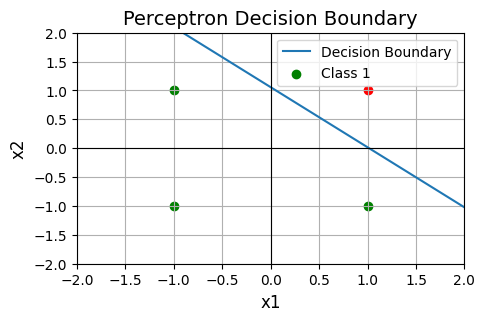

,Input,Predicted,True
0,"[-1, -1]",[1.2722854915984214],1
1,"[-1, 1]",[0.4506987950236194],1
2,"[1, -1]",[0.41773270004513785],1
3,"[1, 1]",[-0.40385399652966414],-1


In [143]:
# Example 1 from the presentation:
# Data and parameters:
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])

print_progress = True
learning_rate = 0.03
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [144]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
true_outputs = np.array([1, 1, 1, -1])
data_description_orig = "Ex. 1"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False

min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,2.502310e-01,5.000000e-01,100.0,0.008386,iterative,0.01,100,"[[-0.4914438080609323], [-0.4928691337005592]]",4.922753e-01,Ex. 1 non-adaptive 0.0001
1,2.507029e-01,5.000000e-01,100.0,0.008599,iterative,0.10,100,"[[-0.5044684573658201], [-0.4863291413602032]]",5.088929e-01,Ex. 1 non-adaptive 0.0001
2,7.568523e+105,3.342420e+52,100.0,0.008600,iterative,1.00,100,"[[2.072439993745895e+50], [-3.774598422272479e...",1.537802e+50,Ex. 1 non-adaptive 0.0001
3,3.670229e-01,5.429055e-01,2.0,0.000195,iterative,0.10,2,"[[-0.36994477350775534], [-0.2636916534758979]]",2.933846e-01,Ex. 1 non-adaptive 0.0001
4,2.567116e-01,5.000000e-01,5.0,0.000435,iterative,0.10,5,"[[-0.4370315031127268], [-0.446818666825944]]",4.508118e-01,Ex. 1 non-adaptive 0.0001
5,2.512454e-01,5.000000e-01,10.0,0.001044,iterative,0.10,10,"[[-0.4718692426991517], [-0.528370482477878]]",5.065036e-01,Ex. 1 non-adaptive 0.0001
6,2.509732e-01,5.000000e-01,20.0,0.003147,iterative,0.10,20,"[[-0.5074034749450996], [-0.5180181888351312]]",4.904714e-01,Ex. 1 non-adaptive 0.0001
7,4.080386e-01,5.910423e-01,100.0,0.015939,iterative,0.01,100,"[[-0.23579659857630297], [-0.29921556165012886]]",2.819399e-01,Ex. 1 adaptive 0.0001
8,2.500008e-01,5.000000e-01,100.0,0.015352,iterative,0.10,100,"[[-0.4986927990583558], [-0.5002511918564787]]",4.999571e-01,Ex. 1 adaptive 0.0001
9,2.510050e-01,5.000000e-01,100.0,0.013818,iterative,1.00,100,"[[-0.48571944036702425], [-0.5123574027259935]]",4.717367e-01,Ex. 1 adaptive 0.0001


### Example 2
- In this example, we train the linear neuron a task with a low number of training patterns
- Observe the training process, does the algorithm converge?
- Are the predicted outputs close to the expected ones?
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process


Gradient Descent iterative:
Epoch: 0, MSE: 0.6991 Weights: [[ 0.01951021 -0.168001  ]] Bias: 0.06364442201723336 Learning rate: 0.1000
Epoch: 1, MSE: 0.4343 Weights: [[-0.00460916 -0.34188924]] Bias: 0.03952505198724286 Learning rate: 0.1000
Epoch: 2, MSE: 0.2707 Weights: [[-0.01782429 -0.47974334]] Bias: 0.026309925012846222 Learning rate: 0.1000
Epoch: 3, MSE: 0.1691 Weights: [[-0.01423399 -0.5890821 ]] Bias: 0.02990022046542922 Learning rate: 0.1000
Epoch: 4, MSE: 0.1055 Weights: [[-0.02131975 -0.67521819]] Bias: 0.02281445802103576 Learning rate: 0.1000
Epoch: 5, MSE: 0.0659 Weights: [[-0.01835593 -0.74343732]] Bias: 0.025778282408348313 Learning rate: 0.1000
Epoch: 6, MSE: 0.0411 Weights: [[-0.01720055 -0.79738971]] Bias: 0.026933662264741715 Learning rate: 0.1000
Epoch: 7, MSE: 0.0257 Weights: [[-0.01702374 -0.8400352 ]] Bias: 0.02711047391247328 Learning rate: 0.1000
Epoch: 8, MSE: 0.0160 Weights: [[-0.02053987 -0.87352694]] Bias: 0.023594346188467057 Learning rate: 0.1000
Epoch

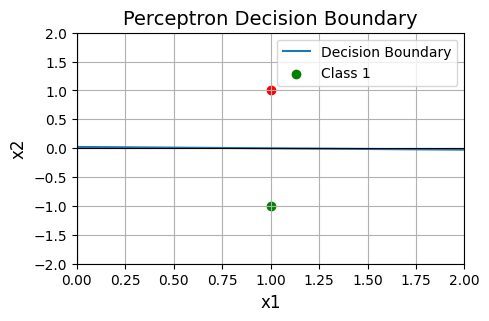

,Input,Predicted,True
0,"[1, -1]",[0.9678656741473416],1
1,"[1, 1]",[-0.9706317163791615],-1


In [145]:
# Example 2 from the presentation:
# Data:
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
print_progress = True
learning_rate = 0.1
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}

df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [146]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs = np.array([[1, -1], [1, 1]])
true_outputs = np.array([1, -1])
data_description_orig = "Ex. 2"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,1.733746e-02,1.314574e-01,100.0,0.008878,iterative,0.01,100,"[[0.06915764137911287], [-0.8804961190139159]]",-6.999771e-02,Ex. 2 non-adaptive 0.0001
1,7.982200e-05,8.906242e-03,20.0,0.001803,iterative,0.10,100,"[[-0.0022058097118118868], [-0.990269064919442]]",1.859726e-03,Ex. 2 non-adaptive 0.0001
2,1.201497e+68,6.546095e+33,100.0,0.009805,iterative,1.00,100,"[[1.3275590774850954e+33], [2.7407766447394654...",1.327559e+33,Ex. 2 non-adaptive 0.0001
3,3.669013e-01,6.035142e-01,2.0,0.000219,iterative,0.10,2,"[[-0.005924547490116408], [-0.35291231663577005]]",1.535300e-02,Ex. 2 non-adaptive 0.0001
4,9.930132e-02,3.142685e-01,5.0,0.000478,iterative,0.10,5,"[[0.06097700561093495], [-0.7137233272958518]]",-5.965324e-02,Ex. 2 non-adaptive 0.0001
5,8.379417e-03,9.134193e-02,10.0,0.000950,iterative,0.10,10,"[[-0.001632574556282143], [-0.9116623677858919]]",6.995464e-03,Ex. 2 non-adaptive 0.0001
6,7.578476e-05,8.689288e-03,20.0,0.002035,iterative,0.10,20,"[[0.05399822731988206], [-0.9913960174150389]]",-5.340091e-02,Ex. 2 non-adaptive 0.0001
7,4.532631e-01,6.711764e-01,100.0,0.008792,iterative,0.01,100,"[[-0.05976628591352674], [-0.31914486500471434]]",6.461661e-02,Ex. 2 adaptive 0.0001
8,2.718055e-04,1.645797e-02,100.0,0.010111,iterative,0.10,100,"[[-0.08558421194557062], [-0.9828319482925522]]",8.562042e-02,Ex. 2 adaptive 0.0001
9,4.851467e-05,4.716498e-03,9.1,0.000814,iterative,1.00,100,"[[0.003783847749465716], [-0.9932264565710254]]",2.266178e-03,Ex. 2 adaptive 0.0001


### Example 3: linear regression
- In this example, we work with data for one-dimensional linear regression
- We work with three independent datasets:
    - training
    - validation - used for early stopping (and to monitor the model performance during the training)
    - testing - used just for final testing (whether the model generalizes well)
- Observe the training process of the iterative training algorithm, does the algorithm converge? Is the neuron function close to the true function? Observe, how the progress of the errors during training
- Compare the error on the training data and on the testing data
- Experiment with the noise levels and with the training parameters (learning rate, maximum number of epochs, weight initialization, adaptive learning rate,...) and observe, how it affects the training process
- Train the model with early stopping (by setting the parameter max_validation_steps to an integer value)

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.1034, Validation MSE: 0.0993 Weights: [[1.35002472]] Bias: 2.9050684244709744 Learning rate: 0.0500
Epoch: 1, Training MSE: 0.0920, Validation MSE: 0.0900 Weights: [[1.46311554]] Bias: 2.9571994907354555 Learning rate: 0.0500
Epoch: 2, Training MSE: 0.0909, Validation MSE: 0.0892 Weights: [[1.52045151]] Bias: 2.9466156485236734 Learning rate: 0.0500
Epoch: 3, Training MSE: 0.0999, Validation MSE: 0.0962 Weights: [[1.5175953]] Bias: 2.855138209994286 Learning rate: 0.0500
Epoch: 4, Training MSE: 0.0909, Validation MSE: 0.0893 Weights: [[1.50067844]] Bias: 2.9509366486702113 Learning rate: 0.0500
Epoch: 5, Training MSE: 0.0913, Validation MSE: 0.0902 Weights: [[1.51950054]] Bias: 2.9717595508273362 Learning rate: 0.0500
Epoch: 6, Training MSE: 0.0921, Validation MSE: 0.0899 Weights: [[1.55524939]] Bias: 2.9240411708744625 Learning rate: 0.0500
Epoch: 7, Training MSE: 0.0910, Validation MSE: 0.0897 Weights: [[1.5053577]] Bias: 2.962647

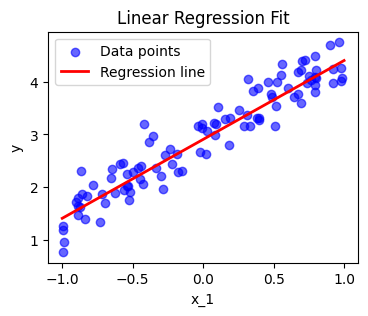

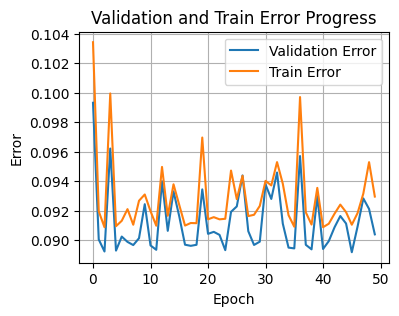

,Input,Predicted,True
0,[0.603219770599182],[3.8083887027147556],3.876124
1,[-0.1852959356948849],[2.6298861357814705],2.622890
2,[0.6996973960506876],[3.9525825701782207],4.383203
3,[0.08223442395484959],[3.0297325980182235],2.993405
4,[0.7630825574093545],[4.047316986716033],4.031124
...,...,...,...
95,[0.5576014822463506],[3.7402083614814954],4.330519
96,[0.8037642211589668],[4.108119130254002],4.063377
97,[0.7998129741020885],[4.10221366158426],4.228023
98,[0.4612921247850561],[3.596265984580379],3.988072


In [220]:
# Example: linear regression
# Training, validation and test data:
inputs, true_outputs           = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)  # y = A x1 + B + noise
test_inputs, test_true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
validation_data                = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

# Parameters:
print_progress = True
learning_rate = 0.05
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 50
max_validation_steps = None # None # no early stopping

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
#perceptron.set_weights(np.array([10000]), 10000) # set weights to large values
[training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)

print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_regression(perceptron, inputs, true_outputs)
plot_error_progress(training_errors, validation_errors)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


#### Example 3 and the batch variant of gradient descent
- observe the training progress, compare it to the iterative variant
- experiment with the learning rate and with the number of epochs

Gradient Descent batch:
Epoch: 0, Training MSE: 0.4849, Validation MSE: 0.4680 Weights: [[0.40433323]] Bias: 2.952402644830528 Learning rate: 0.0100
Epoch: 1, Training MSE: 0.2682, Validation MSE: 0.2596 Weights: [[0.76216849]] Bias: 2.961591051153772 Learning rate: 0.0100
Epoch: 2, Training MSE: 0.1649, Validation MSE: 0.1653 Weights: [[1.00931185]] Bias: 2.969365714872042 Learning rate: 0.0100
Epoch: 3, Training MSE: 0.1155, Validation MSE: 0.1239 Weights: [[1.18003552]] Bias: 2.974735382887219 Learning rate: 0.0100
Epoch: 4, Training MSE: 0.0920, Validation MSE: 0.1066 Weights: [[1.29796936]] Bias: 2.978444685136974 Learning rate: 0.0100
Epoch: 5, Training MSE: 0.0808, Validation MSE: 0.1001 Weights: [[1.37943663]] Bias: 2.981007026172979 Learning rate: 0.0100
Epoch: 6, Training MSE: 0.0754, Validation MSE: 0.0982 Weights: [[1.43571324]] Bias: 2.982777060304438 Learning rate: 0.0100
Epoch: 7, Training MSE: 0.0728, Validation MSE: 0.0981 Weights: [[1.47458843]] Bias: 2.98399977842919

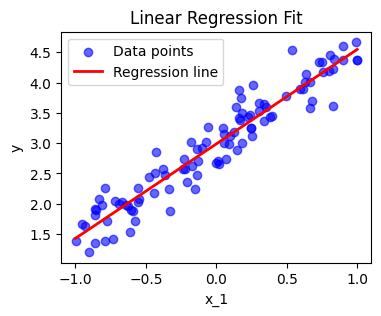

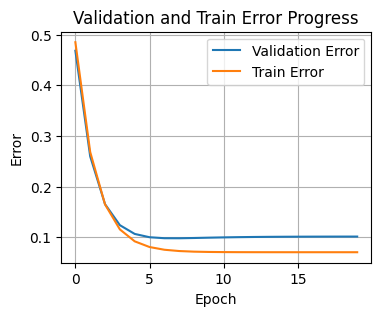

,Input,Predicted,True
0,[0.01985854733198522],[3.0176866106718325],2.656867
1,[-0.8129176178588671],[1.718213346300829],1.973551
2,[0.826535548973903],[4.27643444764481],3.613248
3,[0.14485225741610863],[3.2127281971846195],2.893914
4,[-0.8629742163255381],[1.6401044688716986],1.357487
...,...,...,...
95,[-0.3372541632943393],[2.46044393343981],2.240637
96,[-0.6389233049474883],[1.989716022808294],1.981424
97,[-0.07424054682989989],[2.8708533292019243],3.021878
98,[-0.10121703834091211],[2.828758909416197],2.927477


In [214]:
# Training, validation and test data:
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
validation_data                = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

# Parameters:
print_progress = True
learning_rate = 0.01
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 20
max_validation_steps = None # no early stopping

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
[training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)

# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_regression(perceptron, inputs, true_outputs)
plot_error_progress(training_errors, validation_errors)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- finetune parameters of the iterative / batch algoritm:
    1. learning rate
    2. number of epochs
    3. ...

In [231]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Test MSE', 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
validation_data                = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

data_description_orig = "regr. 1"

# Perceptron parameters:
variant = "iterative" # "batch"
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
max_validation_steps = 5 #None

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate
for learning_rate in [0.001, 0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)

# epochs
learning_rate = 0.01
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Test MSE,Test MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.076784,0.214845,1.889884,1.147364,99.2,0.115701,iterative,0.001,100,[[1.5495367990031839]],2.987339,regr. 1 non-adaptive 0.0001
1,0.076318,0.215153,1.939748,1.164581,100.0,0.116056,iterative,0.010,100,[[1.5842891978008065]],2.972455,regr. 1 non-adaptive 0.0001
2,0.078973,0.219496,1.933818,1.163037,100.0,0.115083,iterative,0.100,100,[[1.5639135199998264]],2.925057,regr. 1 non-adaptive 0.0001
3,0.944523,0.634513,2.730230,1.305661,100.0,0.133655,iterative,1.000,100,[[1.5222380592727607]],3.414902,regr. 1 non-adaptive 0.0001
4,1.690912,1.117278,2.090160,1.164495,1.0,0.001175,iterative,0.010,1,[[0.5327974005130802]],1.899500,regr. 1 non-adaptive 0.0001
5,0.411088,0.514209,1.310672,0.923091,2.0,0.002286,iterative,0.010,2,[[0.8762875502801148]],2.606212,regr. 1 non-adaptive 0.0001
6,0.095972,0.247411,1.654226,1.069006,5.0,0.006011,iterative,0.010,5,[[1.3437873197332881]],2.987225,regr. 1 non-adaptive 0.0001
7,0.076755,0.214992,1.892400,1.148312,10.0,0.011862,iterative,0.010,10,[[1.54897440712459]],2.991009,regr. 1 non-adaptive 0.0001
8,0.076263,0.215262,1.938216,1.164173,20.0,0.022826,iterative,0.010,20,[[1.5858959727154873]],2.984547,regr. 1 non-adaptive 0.0001
9,0.076244,0.215140,0.076244,0.215140,100.0,0.163047,iterative,0.010,100,[[1.5864574768465092]],2.985105,regr. 1 adaptive 0.0001


- comprate the iterative and batch algorithms:
    1. learning rate
    2. error and training time

In [237]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Test MSE', 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs, true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)
validation_data                = generate_regression_data_1D(A=1.5, B=3, std_noise=0.3, number_of_samples=100)

data_description_orig = "regr. 1"

# Perceptron parameters:
variant =  "batch"
adaptive_learning_rate = False
min_error = 0.0001
epochs = 50
learning_rate = 0.05
init_method = 'random'
print_progress = False
max_validation_steps = 5 #None

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate
#for learning_rate in [0.001, 0.01, 0.1]:
#    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)

# epochs
learning_rate = 0.01
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.05 , 0.1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Test MSE,Test MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.529228,0.608012,55.369385,7.169258,1.0,0.000514,batch,0.01,1,[[0.40844211035352523]],2.919894,regr. 1 non-adaptive 0.0001
1,0.283652,0.430577,56.247338,7.224337,2.0,0.000310,batch,0.01,2,[[0.7798040174350427]],2.936617,regr. 1 non-adaptive 0.0001
2,0.097882,0.234088,57.903805,7.318239,5.0,0.001030,batch,0.01,5,[[1.300904489377431]],2.974017,regr. 1 non-adaptive 0.0001
3,0.080159,0.216965,58.566312,7.352714,10.0,0.001382,batch,0.01,10,[[1.4977409048436052]],2.988131,regr. 1 non-adaptive 0.0001
4,0.079840,0.216916,58.668651,7.357908,20.0,0.001803,batch,0.01,20,[[1.5290404613784427]],2.990375,regr. 1 non-adaptive 0.0001
5,0.079842,0.216885,0.079842,0.216885,100.0,0.006550,batch,0.01,100,[[1.5268004461584495]],2.990214,regr. 1 adaptive 0.0001
6,0.079840,0.216924,0.079840,0.216924,100.0,0.009562,batch,0.05,100,[[1.5296027349239536]],2.990415,regr. 1 adaptive 0.0001
7,0.079840,0.216924,0.079840,0.216924,100.0,0.010790,batch,0.10,100,[[1.5296027349239543]],2.990415,regr. 1 adaptive 0.0001


### Example 4 - Linear regression with two input dimensions


-   observe the training process of the iterative training algorithm, does the algorithm converge? Is the neuron function close to the true function?
-  compare the error on the training data and on the testing data
-  experiment with the noise levels and with the training parameters (learning rate, maximum number of epochs, weight initialization, adaptive learning rate,...) and observe, how it affects the training process


Gradient Descent iterative:
Epoch: 0, Training MSE: 0.2727, Validation MSE: 0.3177 Weights: [[1.92949196 2.57200411]] Bias: -4.0091977093560685 Learning rate: 0.0500
Epoch: 1, Training MSE: 0.2062, Validation MSE: 0.2759 Weights: [[2.12202537 2.88738954]] Bias: -3.912972018539314 Learning rate: 0.0354
Epoch: 2, Training MSE: 0.2105, Validation MSE: 0.2872 Weights: [[2.09539598 2.87615003]] Bias: -3.8557421974987944 Learning rate: 0.0289
Epoch: 3, Training MSE: 0.2070, Validation MSE: 0.2707 Weights: [[2.11374539 2.88686144]] Bias: -3.942865648553053 Learning rate: 0.0250
Epoch: 4, Training MSE: 0.2065, Validation MSE: 0.2755 Weights: [[2.11052    2.90280378]] Bias: -3.8963593672507395 Learning rate: 0.0224
Epoch: 5, Training MSE: 0.2073, Validation MSE: 0.2705 Weights: [[2.13660277 2.91725342]] Bias: -3.9453211200399023 Learning rate: 0.0204
Epoch: 6, Training MSE: 0.2064, Validation MSE: 0.2732 Weights: [[2.13403377 2.92620958]] Bias: -3.9134117097082353 Learning rate: 0.0189
Epoch: 7

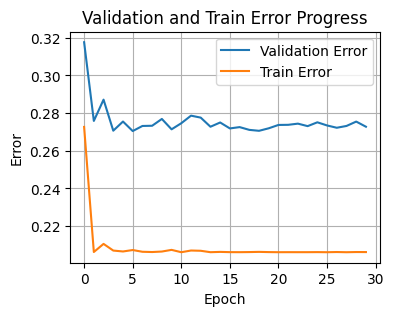

Train Perceptron error: 100, Test PE: 100
Train MAE error: 0.3672395459616968, Test MAE: 0.3974046984000675
Train MSE error: 0.20619804039839346, Test MSE: 0.2366988005957918


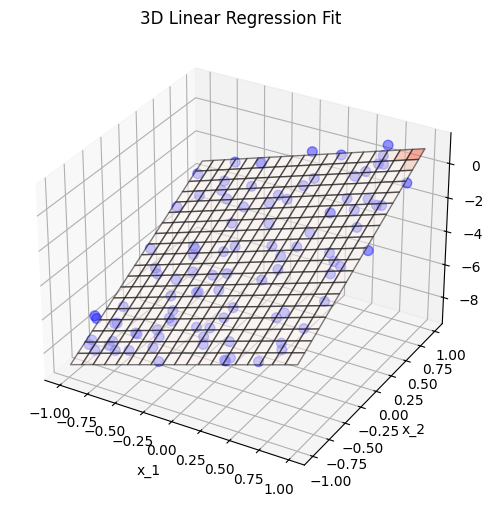

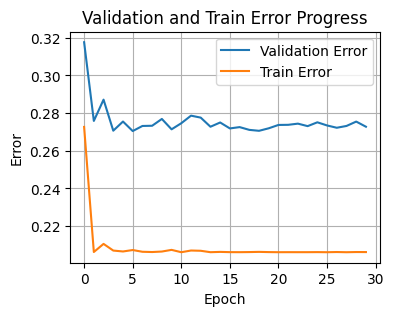

,Input,Predicted,True
0,"[0.2703361058794751, 0.9916800370568237]",[-0.47165933650980074],-0.573062
1,"[-0.8232273307859965, -0.6998093388546645]",[-7.703596403825323],-8.407068
2,"[-0.5217048183950588, -0.19465610743317852]",[-5.597065976150585],-5.610236
3,"[-0.2865125992069246, -0.6760509254460927]",[-6.494468344097043],-5.739631
4,"[0.7917265854751314, 0.2713479893866617]",[-1.454481698417482],-1.563268
...,...,...,...
95,"[0.8154074542113638, -0.1338269891173529]",[-2.5800174057065597],-2.131506
96,"[-0.5964303710373584, 0.837937991329974]",[-2.7591592750479546],-2.055084
97,"[-0.3947554141134455, 0.7487900316504148]",[-2.5894402531253395],-2.862635
98,"[0.5346402009271503, 0.5959325150346202]",[-1.058663666166788],-1.405357


In [238]:
# Define parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
validation_data = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)

# Train the linear neuron:
print_progress = True
learning_rate = 0.05
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 30
variant = "iterative"
max_validation_steps = None # no early stopping

# Train the linear neuron:
perceptron = LinearNeuron(inputs.shape[1], init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)

# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_regression_3D(perceptron, inputs, true_outputs)
plot_error_progress(training_errors, validation_errors)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df

- finetune parameters of the iterative/batch method:

In [164]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
#np.random.seed(42)  # For reproducibility
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
data_description_orig = "regr. 2"
variant = "iterative"

# Perceptron parameters:
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
max_validation_steps = None

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)
learning_rate = 0.1
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)


print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,8.321932,2.322725,100.0,0.119222,iterative,0.01,100,"[[2.1606688272068197], [3.0253584792353503]]",-4.059414,regr. 2 non-adaptive 0.0001
1,8.317519,2.322659,100.0,0.117717,iterative,0.10,100,"[[2.1129153081608143], [2.858331802460395]]",-4.185485,regr. 2 non-adaptive 0.0001
2,9.077136,2.420710,100.0,0.157409,iterative,1.00,100,"[[1.7002282487684681], [2.172876414741578]]",-3.055274,regr. 2 non-adaptive 0.0001
3,7.930807,2.267961,1.0,0.002031,iterative,0.10,1,"[[2.084049760868742], [2.760089949109466]]",-4.095422,regr. 2 non-adaptive 0.0001
4,8.314538,2.321596,2.0,0.003990,iterative,0.10,2,"[[2.1663334744577396], [3.0369011172431946]]",-4.082420,regr. 2 non-adaptive 0.0001
5,8.437243,2.339047,5.0,0.010547,iterative,0.10,5,"[[2.109157326604807], [3.067521636280733]]",-4.136521,regr. 2 non-adaptive 0.0001
6,8.361276,2.327960,10.0,0.021340,iterative,0.10,10,"[[2.218723482690912], [3.0431763203227153]]",-3.963583,regr. 2 non-adaptive 0.0001
7,8.369299,2.329036,20.0,0.040321,iterative,0.10,20,"[[2.332216772306815], [2.930987199507221]]",-4.071859,regr. 2 non-adaptive 0.0001
